# ML Task 2.2 - Complex ML models and keras - Part 1

## Table of Contents

#### 01. Import libraries and datasets

#### 02. Data preprocessing

#### 03. Reshape the datasets for RNN (LSTM variant) and CNN model input

#### 04. Caveat: Dataset preprocessing structural mismatch with answers dataset; unscaled data problem

#### 05. Build the RNN (LSTM variant) model

#### 06. Compile, run the RNN (LSTM variant) model

#### 07. Confusion matrix

#### 08. Further RNN (LSTM variant) model runs, confusion matrices on changed hyperparameters

### 09. Bonus Task 2: Weather dataset preprocessing changes, z-score scaling, LSTM model build & run, confusion matrices, learning curves

### 01. Import libraries and datasets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from numpy import unique
from numpy import reshape
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, Dense, BatchNormalization, Flatten, MaxPooling1D, Dropout, LSTM, Input # changed line
from sklearn.model_selection import train_test_split
from keras import utils # changed line
from keras.utils import to_categorical  # changed line

In [4]:
# Create path to dataset location
path = r'C:\Users\dirk8\CareerFoundry\07-2025 Machine Learning With Python\Datasets\Unsupervised'

In [12]:
# Import unscaled weather dataset and Pleasant Weather answers dataset, respectively, without the index column
df_unscaled = pd.read_excel(os.path.join(path, 'cleaned_weather_data_task_2.2.xlsx'), index_col=None)
pleas_ans = pd.read_excel(os.path.join(path, 'answers_pleasant_weather_no_date.xlsx'), index_col=None)

### 02. Data preprocessing

#### Comment: The unscaled weather dataset uploaded here was already preprocessed in the Excel file as follows: (i) 'DATE' and 'MONTH' columns were dropped as we only need numerical data for the RNN (LSTM) and CNN model inputs; (ii) Roma, Gdansk & Tours weather stations and all their associated weather features (columns) were dropped; (iii) the 'snow_depth' (only 6 weather stations had this feature) and 'wind_speed' (only 9 weather stations had this feature) weather features (columns) were dropped from ALL weather stations, to ensure that we have an identical (and in the exact same sequence) set of nine (9) weather features per weather station; (iv) 'cloud_cover' weather feature was only missing for Kassel weather station, so Dusseldorf (229 km away, similar latitude) weather station's data series for that feature was copied to Kassel; (v) 'pressure' weather feature was only missing for MunchenB weather station, so Basel (which has a closer latitude to Munich than Sonnblick does, and a 260-metre elevation versus Sonnblick's 3,100 metres) weather station's data series for that feature was copied to MunchenB; and (vi) 'humidity' weather feature was only missing for Stockholm weather station, so Oslo (similar latitude, also a coastal city) weather station's data series for that feature was copied to Stockholm.

#### Meanwhile, in the Pleasant weather answers dataset uploaded here, the 'DATE' column was dropped as it is not needed for the RNN and CNN model runs in this exercise.

In [19]:
# Check dimensions
print(df_unscaled.shape)
print(pleas_ans.shape)

(22950, 135)
(22950, 15)


In [23]:
# Check a few lines of the weather dataset
df_unscaled.head(2)

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1


In [25]:
# Check a few lines of the Pleasant weather answers dataset
pleas_ans.head(2)

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Check for missing data in the weather dataset
df_unscaled.isnull().sum().sum()

0

In [31]:
# Check for missing data in the Pleasant weather answers dataset
pleas_ans.isnull().sum().sum()

0

#### Comment: No export of the datasets is needed as these were already preprocessed in Excel form, as confirmed above.

### 03. Reshape the datasets for RNN (LSTM variant) and CNN model input

In [46]:
# Create NumPy arrays for the weather dataset and Pleasant weather answers dataset
# Then check unscaled weather data array
X = np.array(df_unscaled)
y = np.array(pleas_ans)
X

array([[ 7.    ,  0.85  ,  1.018 , ...,  8.5   ,  6.    , 10.9   ],
       [ 6.    ,  0.84  ,  1.018 , ...,  8.9   ,  5.6   , 12.1   ],
       [ 8.    ,  0.9   ,  1.018 , ..., 10.5   ,  8.1   , 12.9   ],
       ...,
       [ 4.    ,  0.76  ,  1.0227, ..., 10.7   ,  7.9   , 13.5   ],
       [ 5.    ,  0.8   ,  1.0212, ..., 10.7   ,  7.9   , 13.5   ],
       [ 5.    ,  0.84  ,  1.0193, ..., 10.7   ,  7.9   , 13.5   ]])

In [48]:
# Check answers array
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [50]:
# For DL model compatibility, the X NumPy array needs to be reshaped to 15 groups of 9 features
# Meanwhile, the y (Pleasant weather answers) NumPy array is already structured as 15 groups so does not need reshaping
X = X.reshape(-1,15,9)

In [56]:
# Check dimensions
X.shape

(22950, 15, 9)

In [52]:
# Check the first row (index 0) of the array, then the first element (index 0) within that selected row
X[0][0]

array([ 7.   ,  0.85 ,  1.018,  0.32 ,  0.09 ,  0.7  ,  6.5  ,  0.8  ,
       10.9  ])

In [60]:
# Check y dimensions
y.shape

(22950, 15)

### Split datasets into training & testing subsets

In [62]:
# Set the global random seed for TensorFlow's random number generators
# This allows reproducibility in model training when re-running the code
tf.random.set_seed(42)

In [65]:
# Split data into train and test sets
# Note that train_test_split() uses its own internal random number generator, which is independent of TensorFlow's seed ...
# thus the random_state=42 argument is still needed

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [69]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17212, 15, 9) (17212, 15)
(5738, 15, 9) (5738, 15)


In [71]:
len(X_train[0])

15

In [73]:
len(X_train[0][0])

9

In [77]:
# Check the first row (index 0) of the array, then the first element (index 0) within that selected row
X_train[0][0]

array([ 2.    ,  0.69  ,  1.0131,  2.45  ,  0.06  ,  6.9   , 20.4   ,
       13.6   , 26.9   ])

In [79]:
len(y_train[0])

15

## 04. Caveat: Dataset preprocessing structural mismatch with answers dataset; unscaled data problem

The next sections comply with the Task 2.2-provided instructions, which are flawed. These required a reshaped (22950, 15, 9) NumPy array structure for X prior to train/test splitting.  And, required use of unscaled weather data, which is problematic for DL model performance.

## The Bonus Task section (further below) attempts to fix some of these problems.

### 05. Build the RNN (LSTM variant) model

In [86]:
# This build follows the Exercise 2.2 code examples given
# The Input shape line of code was added to adjust to the recent evolution of tensorflow/keras libraries and avoid a warning message

epochs = 30
batch_size = 20
n_hidden = 8

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

model = Sequential()
model.add(Input(shape=(timesteps, input_dim))) # Added this line to keep up with ML library evolution
model.add(LSTM(n_hidden))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='tanh'))  # Note: avoid 'relu' for LSTM model activation, problematic

In [88]:
# Output model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8)                   │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 15)                  │             135 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711 (2.78 KB)

 Trainable params: 711 (2.78 KB)

 Non-trainable params: 0 (0.00 B)

### 06. Compile, run the RNN (LSTM variant) model

In [91]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [93]:
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1656 - loss: 25.4094 - val_accuracy: 0.2349 - val_loss: 25.0543
Epoch 2/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1190 - loss: 23.8224 - val_accuracy: 0.0059 - val_loss: 20.8016
Epoch 3/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0743 - loss: 23.4419 - val_accuracy: 0.0270 - val_loss: 22.2968
Epoch 4/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0248 - loss: 23.5857 - val_accuracy: 0.0141 - val_loss: 21.6688
Epoch 5/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0290 - loss: 23.7614 - val_accuracy: 0.0336 - val_loss: 30.2996
Epoch 6/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0244 - loss: 24.0853 - val_accuracy: 0.0338 - val_loss: 30.7280
Epoch 7/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0242 - loss: 24.1029 - val_accuracy: 0.0359 - val_loss: 31.6912
Epoch 8/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0162 - loss: 24.2867 - v

### 07. Confusion matrix

#### Caveat: the confusion matrix structure or labeling, using weather station names rather than Pleasant/Unpleasant weather answers labels, is another type of "mismatch" arising from the Task 2.2-required preprocessing format or structure for the weather dataset NumPy array.

In [98]:
# Create a dictionary of labels to be referenced by the confusion matrix custom defined function further below
stations = {
0: 'BASEL',
1: 'BELGRADE',
2: 'BUDAPEST',
3: 'DEBILT',
4: 'DUSSELDORF',
5: 'HEATHROW',
6: 'KASSEL',
7: 'LJUBLJANA',
8: 'MAASTRICHT',
9: 'MADRID',
10: 'MUNCHENB',
11: 'OSLO',
12: 'SONNBLICK',
13: 'STOCKHOLM',
14: 'VALENTIA'
}

In [100]:
# Define a custom function to output a confusion matrix as per Exercise 2.2-provided examples

def confusion_matrix(y_true, y_pred):
    y_true = pd.Series([stations[y] for y in np.argmax(y_true, axis=1)])
    y_pred = pd.Series([stations[y] for y in np.argmax(y_pred, axis=1)])

    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Pred'])

In [104]:
# Output the confusion matrix using the defined custom function
print(confusion_matrix(y_test, model.predict(X_test)))

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Pred        BUDAPEST  MAASTRICHT  STOCKHOLM
True                                       
BASEL           3668           7          7
BELGRADE        1092           0          0
BUDAPEST         214           0          0
DEBILT            82           0          0
DUSSELDORF        29           0          0
HEATHROW          82           0          0
KASSEL            11           0          0
LJUBLJANA         61           0          0
MAASTRICHT         9           0          0
MADRID           458           0          0
MUNCHENB           8           0          0
OSLO               5           0          0
STOCKHOLM          4           0          0
VALENTIA           1           0          0


## Comment: the first run using the LSTM variant of the RNN model had terrible results, far, far worse than tossing a coin (50/50) to determine the daily weather outcome (as Pleasant "1" or Unpleasant "0") at each weather station.  Overall accuracy 1.8%, loss 25.8 on the 30th epoch, with an output confusion matrix that appears meaningless. Nonetheless, some changes to hyperparameters are made below (next section) as per Task 2.2 instructions.  We will see what happens under some adjustments.

### 08. Further RNN (LSTM variant) model runs, confusion matrices on changed hyperparameters

In [117]:
epochs = 30
batch_size = 16
n_hidden = 24

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

model = Sequential()
model.add(Input(shape=(timesteps, input_dim))) # Added this line to keep up with ML library evolution
model.add(LSTM(n_hidden))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))  # Note: avoid 'relu' for LSTM model activation, problematic

In [119]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 24)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │             375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,639 (14.21 KB)

 Trainable params: 3,639 (14.21 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [123]:
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1451 - loss: 9.9623 - val_accuracy: 0.2593 - val_loss: 8.3779
Epoch 2/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2739 - loss: 10.0335 - val_accuracy: 0.2572 - val_loss: 8.7293
Epoch 3/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2793 - loss: 10.1891 - val_accuracy: 0.2646 - val_loss: 9.0875
Epoch 4/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3172 - loss: 10.3916 - val_accuracy: 0.2778 - val_loss: 9.3471
Epoch 5/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4564 - loss: 10.5490 - val_accuracy: 0.6406 - val_loss: 9.6841
Epoch 6/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5655 - loss: 10.7600 - val_accuracy: 0.6410 - val_loss: 9.9851
Epoch 7/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6109 - loss: 10.9443 - val_accuracy: 0.6415 - val_loss: 10.2624
Epoch 8/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6323 - loss: 11

In [125]:
print(confusion_matrix(y_test, model.predict(X_test)))

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Pred        BASEL  BELGRADE  LJUBLJANA  MADRID
True                                          
BASEL        3680         0          0       2
BELGRADE     1089         1          1       1
BUDAPEST      214         0          0       0
DEBILT         82         0          0       0
DUSSELDORF     29         0          0       0
HEATHROW       82         0          0       0
KASSEL         11         0          0       0
LJUBLJANA      61         0          0       0
MAASTRICHT      9         0          0       0
MADRID        458         0          0       0
MUNCHENB        8         0          0       0
OSLO            5         0          0       0
STOCKHOLM       4         0          0       0
VALENTIA        1         0          0       0


#### Comment: While this appears to improve on prior results, it did not.  A concurrent increase in both accuracy and loss metrics, by the 30th epoch, suggests the LSTM is becoming overconfident in its wrong predictions, a classic sign of overfitting, especially when using a loss function like crossentropy.  The concurrent increase of both metrics tells us the model is memorizing the training data instead of learning to generalize to unseen (test) data. Output confusion matrix remains meaningless.

In [131]:
epochs = 30
batch_size = 16
n_hidden = 16

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

model = Sequential()
model.add(Input(shape=(timesteps, input_dim))) # Added this line to keep up with ML library evolution
model.add(LSTM(n_hidden))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='tanh'))  # Note: avoid 'relu' for LSTM model activation, problematic

In [133]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 16)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 15)                  │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,919 (7.50 KB)

 Trainable params: 1,919 (7.50 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [137]:
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1311 - loss: 24.1030 - val_accuracy: 0.3806 - val_loss: 30.3868
Epoch 2/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1343 - loss: 24.2099 - val_accuracy: 0.2553 - val_loss: 23.2056
Epoch 3/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1547 - loss: 23.3973 - val_accuracy: 0.3780 - val_loss: 20.5063
Epoch 4/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1722 - loss: 22.7614 - val_accuracy: 0.3705 - val_loss: 24.8513
Epoch 5/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1390 - loss: 23.1631 - val_accuracy: 0.3749 - val_loss: 23.8817
Epoch 6/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1660 - loss: 22.7752 - val_accuracy: 0.4582 - val_loss: 26.1030
Epoch 7/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2330 - loss: 23.7177 - val_accuracy: 0.4130 - val_loss: 25.7623
Epoch 8/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2362 - l

In [139]:
print(confusion_matrix(y_test, model.predict(X_test)))

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Pred        BASEL
True             
BASEL        3682
BELGRADE     1092
BUDAPEST      214
DEBILT         82
DUSSELDORF     29
HEATHROW       82
KASSEL         11
LJUBLJANA      61
MAASTRICHT      9
MADRID        458
MUNCHENB        8
OSLO            5
STOCKHOLM       4
VALENTIA        1


#### Comment: these latest results (NaNs for the loss function output, after the 9th epoch) suggest possible "exploding gradients", a common issue in LSTMs.  It can arise during backpropagation, where the error signals can grow exponentially and overwhelm the floating-point precision.  Or if the loss function (under categorical_crossentropy) calculates a logarithm of zero, the logarithm becomes negative infinity or NaN.  This happens if the model predicts a probability of exactly zero for the correct class.  Other reasons include the rmsprop optimizer setting an initially high learning rate, causing unstable weight updates, or an unstable combination of model architecture and hyperparameters. Some fixes include gradient clipping (setting a maximum value to limit gradient magnitude), explicitly reducing the learning rate, using batch normalization layers to stabilize the learning process, or revisiting preprocessing of the data and normalization (which was not performed, the above model runs all used unscaled weather data).

### 09. Bonus Task 2: Weather dataset preprocessing changes, z-score scaling

In [154]:
print(df_unscaled.shape)
print(pleas_ans.shape)

(22950, 135)
(22950, 15)


In [156]:
df_unscaled.head(2)

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1


In [160]:
pleas_ans.head(2)

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### To correct some of the key problems that arose from the Task 2.2 instructions, we need to (i) structure the datasets and run the DL models on a per-station basis (not on the group), to enable like-with-like matching with the binary answers dataset, which has one data value (binary outcome) per day per station; and (ii) z-score rescale (standardize) the weather data, whose measurements otherwise have differing scales when left in their original form (posing non-uniform scale problems for DL models).

Why not use MinMax normalization similar to the +1 to -1 scale in the HAR (Human Activity Recognition) case study? MinMax normalization is sensitive to outliers (a single extreme outlier can "squash" the rest of the data into a very small range, shrouding useful patterns within), while z-score standardization is more robust to these. MinMax also relies on minimum and maximum values, and if new data points fall outside the original range, the scaling will be incorrect. This is a material "bounded data" weak point for any model seeking to make predictions on unseen, future weather data (which can easily move beyond maxima and/or minima).

#### The defined function wrapped in the script below prepares the per-station weather data for both the LSTM variant (of RNN) and CNN models using 30-day sliding windows.  30 days was selected as the "timestep" to capture shorter-cycle weather patterns in a rolling-window.  Temperature-related features were confirmed in an earlier Exercise's PACF plots to be highly autocorrelated over time.  Recent weather, for at least some weather features, tends to impact heavily what comes next.  The script below covers:

1. Splitting the df_unscaled and pleas_ans datasets into 15 per-station datasets
2. Train/test splitting (75/25)
3. StandardScaler fit (on train only)
4. Scaling train and test sets
5. Reshaping data for deep learning with a window size of 30 timesteps
6. Storing reshaped datasets in a structured dictionary per station

In [168]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Config
stations = [
    'BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW', 'KASSEL',
    'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA'
]
features_per_station = 9
timesteps = 30
test_size = 0.25
random_state = 42

# Output dictionary
data_per_station = {}

# 1–6: Preprocessing Loop
for station in stations:
    # 1. Slice weather + label for the station
    X_full = df_unscaled.loc[:, df_unscaled.columns.str.startswith(f"{station}_")].copy().values
    y_full = pleas_ans[f"{station}_pleasant_weather"].values

    # 2. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=test_size, random_state=random_state, shuffle=False
    )

    # 3. Fit scaler only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Create windowed sequences for LSTM/CNN
    def create_sequences(X, y, window):
        Xs, ys = [], []
        for i in range(window, len(X)):
            Xs.append(X[i-window:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, timesteps)

    # 5. Save to dictionary
    data_per_station[station] = {
        'X_train': X_train_seq,
        'X_test': X_test_seq,
        'y_train': y_train_seq,
        'y_test': y_test_seq,
        'scaler': scaler
    }

print(f"✅ Preprocessed data for {len(data_per_station)} stations.")
print(f"Example shape (X_train) for BASEL:", data_per_station['BASEL']['X_train'].shape)

✅ Preprocessed data for 15 stations.
Example shape (X_train) for BASEL: (17182, 30, 9)


#### Next, the script below builds, trains and evaluates an LSTM (variant of RNN) model for each of the 15 weather stations. This is done in a batch-processing loop, generating per-station results with:

* Balanced accuracy
* Weighted F1 score
* Precision
* Recall
* Confusion matrix

Note: "Balanced Accuracy" is preferred over "Overall Accuracy" when the answers dataset has a class imbalance (e.g., approximately 75% of the days over 60+ years were recorded as "Unpleasant" weather, with only 25% as "Pleasant"), which makes predicting the minority class outcome more challenging.


🌀 Processing station: BASEL
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8011 - loss: 0.3798 - precision: 0.5877 - recall: 0.5608 - val_accuracy: 0.8169 - val_loss: 0.3650 - val_precision: 0.6660 - val_recall: 0.6613
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8166 - loss: 0.3518 - precision: 0.6218 - recall: 0.5927 - val_accuracy: 0.8257 - val_loss: 0.3532 - val_precision: 0.6792 - val_recall: 0.6857
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8206 - loss: 0.3456 - precision: 0.6262 - recall: 0.6178 - val_accuracy: 0.8299 - val_loss: 0.3478 - val_precision: 0.6833 - val_recall: 0.7030
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8253 - loss: 0.3424 - precision: 0.6336 - recall: 0.6370 - val_accuracy: 0.8301 - val_loss: 0.3434 - val_precision: 0.6849 - val_recall: 0.6998
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8262 - loss: 0.3389 - precision: 0.6384 - recall: 0.62

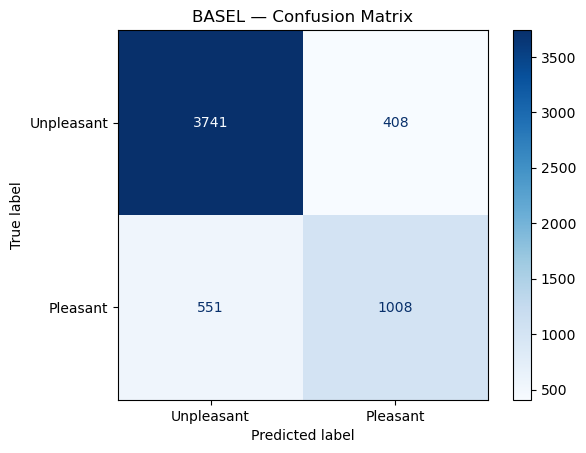


🌀 Processing station: BELGRADE
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7755 - loss: 0.4397 - precision: 0.6479 - recall: 0.7388 - val_accuracy: 0.8045 - val_loss: 0.4111 - val_precision: 0.7175 - val_recall: 0.8008
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7963 - loss: 0.4109 - precision: 0.6791 - recall: 0.7558 - val_accuracy: 0.8118 - val_loss: 0.3992 - val_precision: 0.7219 - val_recall: 0.8211
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7986 - loss: 0.4012 - precision: 0.6825 - recall: 0.7582 - val_accuracy: 0.8111 - val_loss: 0.3894 - val_precision: 0.7244 - val_recall: 0.8119
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8048 - loss: 0.3945 - precision: 0.6919 - recall: 0.7639 - val_accuracy: 0.8146 - val_loss: 0.3871 - val_precision: 0.7266 - val_recall: 0.8211
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8074 - loss: 0.3914 - precision: 0.6941 - recall: 0.

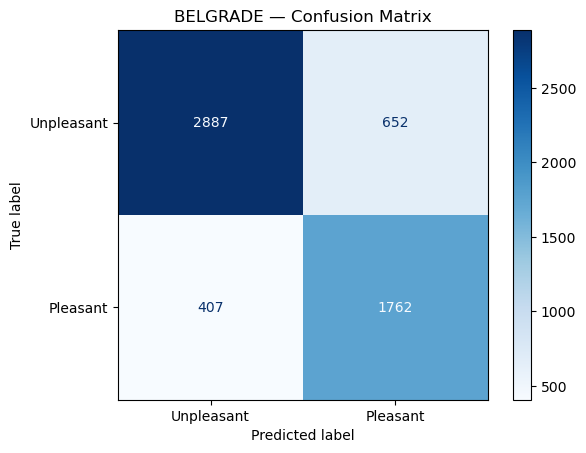


🌀 Processing station: BUDAPEST
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7953 - loss: 0.3987 - precision: 0.6511 - recall: 0.7898 - val_accuracy: 0.8194 - val_loss: 0.3927 - val_precision: 0.6795 - val_recall: 0.8530
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8145 - loss: 0.3687 - precision: 0.6783 - recall: 0.8100 - val_accuracy: 0.8222 - val_loss: 0.3852 - val_precision: 0.6869 - val_recall: 0.8439
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8194 - loss: 0.3586 - precision: 0.6851 - recall: 0.8163 - val_accuracy: 0.8241 - val_loss: 0.3769 - val_precision: 0.6931 - val_recall: 0.8348
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8213 - loss: 0.3576 - precision: 0.6875 - recall: 0.8197 - val_accuracy: 0.8264 - val_loss: 0.3741 - val_precision: 0.6933 - val_recall: 0.8466
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8252 - loss: 0.3526 - precision: 0.6912 - recall: 0.

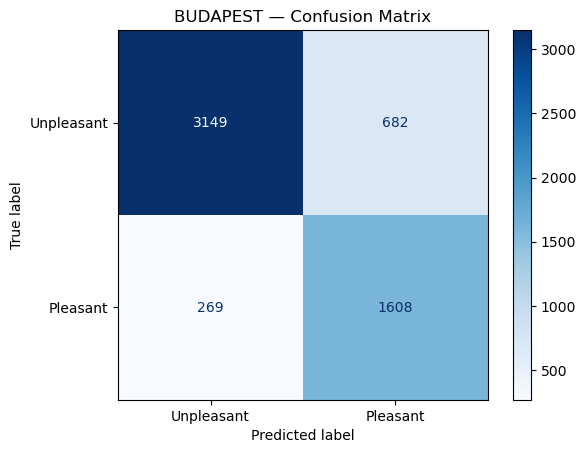


🌀 Processing station: DEBILT
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8468 - loss: 0.3272 - precision: 0.6095 - recall: 0.4824 - val_accuracy: 0.8390 - val_loss: 0.3234 - val_precision: 0.6705 - val_recall: 0.5490
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8664 - loss: 0.2881 - precision: 0.6706 - recall: 0.5481 - val_accuracy: 0.8430 - val_loss: 0.3110 - val_precision: 0.6886 - val_recall: 0.5427
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8696 - loss: 0.2807 - precision: 0.6809 - recall: 0.5575 - val_accuracy: 0.8465 - val_loss: 0.3052 - val_precision: 0.7107 - val_recall: 0.5278
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8728 - loss: 0.2764 - precision: 0.6960 - recall: 0.5572 - val_accuracy: 0.8493 - val_loss: 0.3021 - val_precision: 0.7137 - val_recall: 0.5435
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8733 - loss: 0.2736 - precision: 0.6964 - recall: 0.56

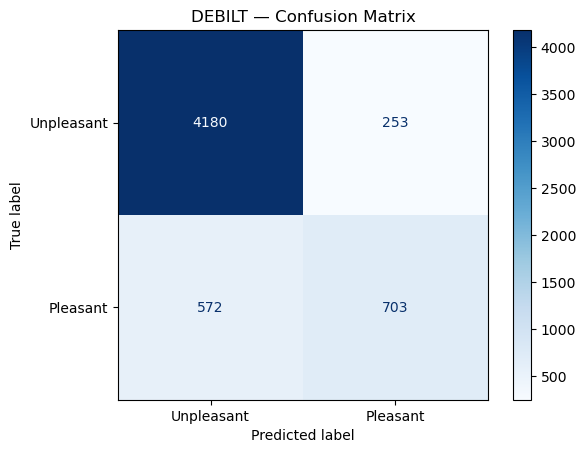


🌀 Processing station: DUSSELDORF
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8178 - loss: 0.3560 - precision: 0.5723 - recall: 0.4849 - val_accuracy: 0.8120 - val_loss: 0.3598 - val_precision: 0.6070 - val_recall: 0.6083
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8373 - loss: 0.3188 - precision: 0.6270 - recall: 0.5342 - val_accuracy: 0.8190 - val_loss: 0.3506 - val_precision: 0.6225 - val_recall: 0.6193
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8478 - loss: 0.3090 - precision: 0.6498 - recall: 0.5793 - val_accuracy: 0.8204 - val_loss: 0.3481 - val_precision: 0.6215 - val_recall: 0.6384
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8460 - loss: 0.3083 - precision: 0.6492 - recall: 0.5622 - val_accuracy: 0.8234 - val_loss: 0.3466 - val_precision: 0.6340 - val_recall: 0.6201
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8474 - loss: 0.3049 - precision: 0.6510 - recall:

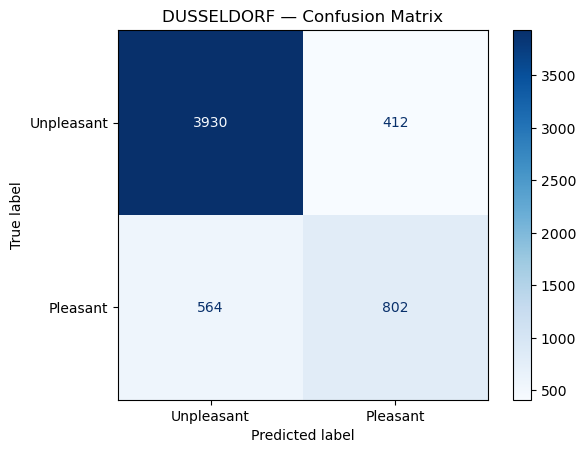


🌀 Processing station: HEATHROW
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8294 - loss: 0.3453 - precision: 0.5924 - recall: 0.5820 - val_accuracy: 0.8245 - val_loss: 0.3328 - val_precision: 0.6185 - val_recall: 0.7119
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8572 - loss: 0.2943 - precision: 0.6778 - recall: 0.5998 - val_accuracy: 0.8397 - val_loss: 0.3123 - val_precision: 0.6580 - val_recall: 0.6996
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8670 - loss: 0.2805 - precision: 0.7062 - recall: 0.6197 - val_accuracy: 0.8464 - val_loss: 0.3019 - val_precision: 0.6755 - val_recall: 0.6996
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8704 - loss: 0.2751 - precision: 0.7101 - recall: 0.6389 - val_accuracy: 0.8495 - val_loss: 0.2964 - val_precision: 0.6779 - val_recall: 0.7177
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8718 - loss: 0.2718 - precision: 0.7123 - recall: 0.

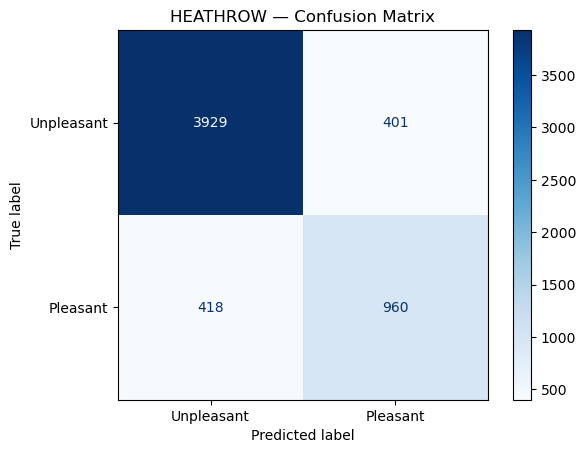


🌀 Processing station: KASSEL
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8307 - loss: 0.3359 - precision: 0.5691 - recall: 0.4433 - val_accuracy: 0.9289 - val_loss: 0.1878 - val_precision: 0.6429 - val_recall: 0.4728
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8535 - loss: 0.2966 - precision: 0.6420 - recall: 0.5144 - val_accuracy: 0.9329 - val_loss: 0.1859 - val_precision: 0.6719 - val_recall: 0.4981
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8551 - loss: 0.2899 - precision: 0.6433 - recall: 0.5301 - val_accuracy: 0.9350 - val_loss: 0.1765 - val_precision: 0.6877 - val_recall: 0.5097
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8594 - loss: 0.2857 - precision: 0.6547 - recall: 0.5485 - val_accuracy: 0.9368 - val_loss: 0.1696 - val_precision: 0.6937 - val_recall: 0.5331
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8607 - loss: 0.2836 - precision: 0.6583 - recall: 0.55

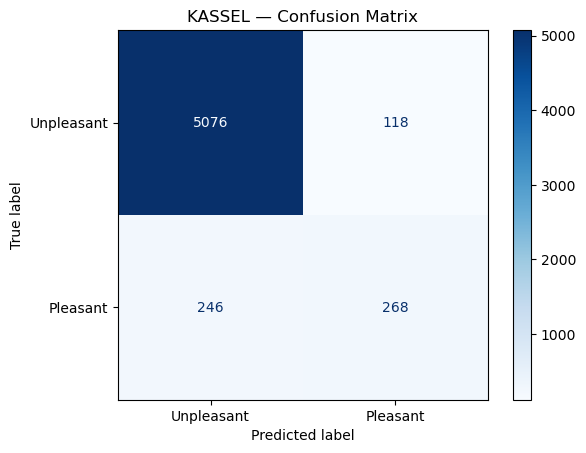


🌀 Processing station: LJUBLJANA
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7827 - loss: 0.4028 - precision: 0.5908 - recall: 0.6235 - val_accuracy: 0.8015 - val_loss: 0.3905 - val_precision: 0.6582 - val_recall: 0.7366
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8004 - loss: 0.3681 - precision: 0.6205 - recall: 0.6631 - val_accuracy: 0.8110 - val_loss: 0.3769 - val_precision: 0.6678 - val_recall: 0.7657
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8101 - loss: 0.3618 - precision: 0.6393 - recall: 0.6737 - val_accuracy: 0.8141 - val_loss: 0.3687 - val_precision: 0.6723 - val_recall: 0.7708
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8095 - loss: 0.3565 - precision: 0.6366 - recall: 0.6792 - val_accuracy: 0.8171 - val_loss: 0.3654 - val_precision: 0.6779 - val_recall: 0.7714
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8151 - loss: 0.3534 - precision: 0.6461 - recall: 0

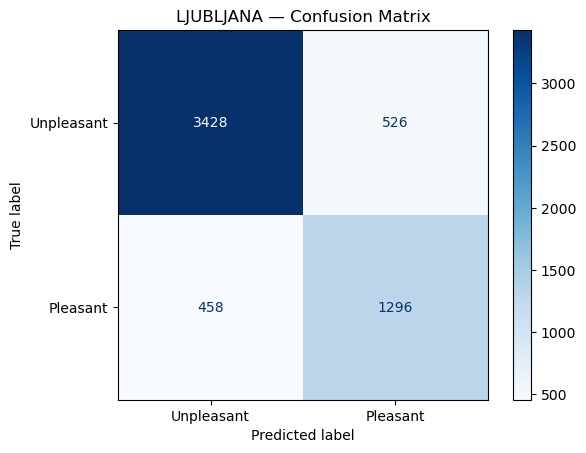


🌀 Processing station: MAASTRICHT
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8342 - loss: 0.3365 - precision: 0.6012 - recall: 0.4734 - val_accuracy: 0.8287 - val_loss: 0.3413 - val_precision: 0.6600 - val_recall: 0.5987
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8572 - loss: 0.3014 - precision: 0.6676 - recall: 0.5490 - val_accuracy: 0.8383 - val_loss: 0.3307 - val_precision: 0.6638 - val_recall: 0.6691
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8604 - loss: 0.2937 - precision: 0.6679 - recall: 0.5812 - val_accuracy: 0.8402 - val_loss: 0.3275 - val_precision: 0.6876 - val_recall: 0.6197
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8648 - loss: 0.2890 - precision: 0.6811 - recall: 0.5912 - val_accuracy: 0.8415 - val_loss: 0.3242 - val_precision: 0.6979 - val_recall: 0.6052
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8672 - loss: 0.2836 - precision: 0.6864 - recall: 

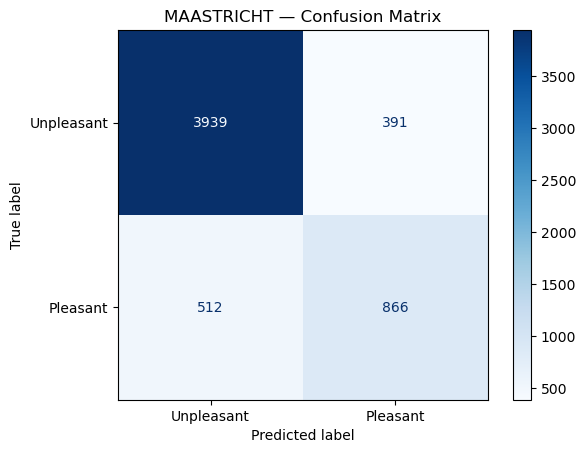


🌀 Processing station: MADRID
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8506 - loss: 0.3583 - precision: 0.8097 - recall: 0.8587 - val_accuracy: 0.8605 - val_loss: 0.3265 - val_precision: 0.8377 - val_recall: 0.8831
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8637 - loss: 0.3215 - precision: 0.8160 - recall: 0.8869 - val_accuracy: 0.8697 - val_loss: 0.3112 - val_precision: 0.8414 - val_recall: 0.9005
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8677 - loss: 0.3104 - precision: 0.8189 - recall: 0.8937 - val_accuracy: 0.8730 - val_loss: 0.3106 - val_precision: 0.8467 - val_recall: 0.9009
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8699 - loss: 0.3092 - precision: 0.8210 - recall: 0.8967 - val_accuracy: 0.8768 - val_loss: 0.3044 - val_precision: 0.8499 - val_recall: 0.9056
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8739 - loss: 0.3045 - precision: 0.8250 - recall: 0.90

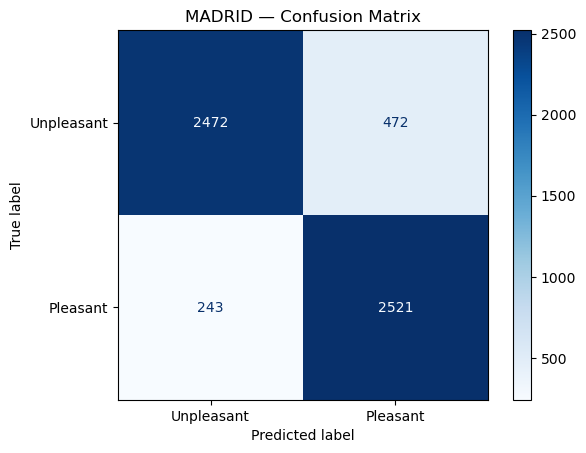


🌀 Processing station: MUNCHENB
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8099 - loss: 0.3617 - precision: 0.5273 - recall: 0.3445 - val_accuracy: 0.7971 - val_loss: 0.3780 - val_precision: 0.6393 - val_recall: 0.3677
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8297 - loss: 0.3320 - precision: 0.5905 - recall: 0.4448 - val_accuracy: 0.8047 - val_loss: 0.3708 - val_precision: 0.6564 - val_recall: 0.4017
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8334 - loss: 0.3252 - precision: 0.6004 - recall: 0.4643 - val_accuracy: 0.8066 - val_loss: 0.3675 - val_precision: 0.6523 - val_recall: 0.4271
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 15981s 15s/step - accuracy: 0.8347 - loss: 0.3242 - precision: 0.6021 - recall: 0.4761 - val_accuracy: 0.8089 - val_loss: 0.3650 - val_precision: 0.6575 - val_recall: 0.4358
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8358 - loss: 0.3219 - precision: 0.6084 - recall

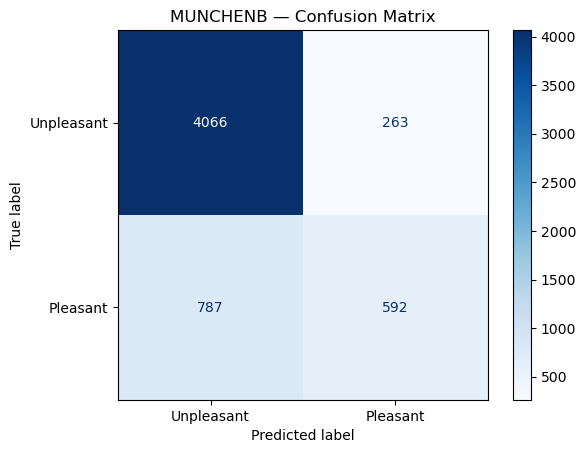


🌀 Processing station: OSLO
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8635 - loss: 0.2806 - precision: 0.5848 - recall: 0.4119 - val_accuracy: 0.8612 - val_loss: 0.2668 - val_precision: 0.5705 - val_recall: 0.5480
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8895 - loss: 0.2329 - precision: 0.6831 - recall: 0.5351 - val_accuracy: 0.8641 - val_loss: 0.2616 - val_precision: 0.5751 - val_recall: 0.5852
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8901 - loss: 0.2292 - precision: 0.6797 - recall: 0.5498 - val_accuracy: 0.8667 - val_loss: 0.2593 - val_precision: 0.5868 - val_recall: 0.5721
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8916 - loss: 0.2231 - precision: 0.6818 - recall: 0.5640 - val_accuracy: 0.8676 - val_loss: 0.2584 - val_precision: 0.5875 - val_recall: 0.5862
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8931 - loss: 0.2228 - precision: 0.6834 - recall: 0.5787

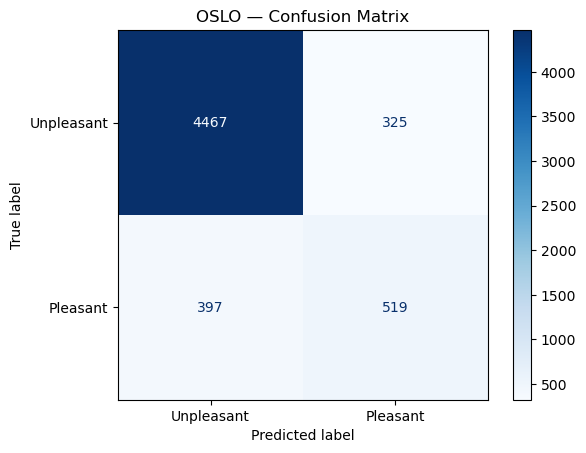


🌀 Processing station: SONNBLICK
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9889 - loss: 0.0371 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 1.0000 - loss: 1.7631e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 4.6545e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 1.0000 - loss: 7.4293e-05 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 2.9471e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 1.0000 - loss: 7.1577e-05 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 2.1250e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
1074/1074 ━━━━━━━━━━

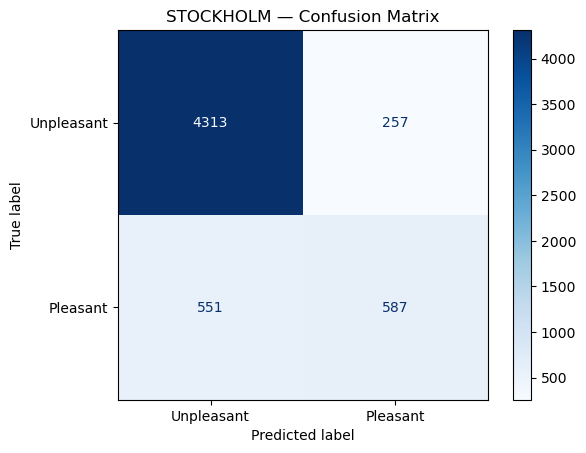


🌀 Processing station: VALENTIA
Epoch 1/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9261 - loss: 0.1978 - precision: 0.2989 - recall: 0.1012 - val_accuracy: 0.9904 - val_loss: 0.0378 - val_precision: 0.5500 - val_recall: 0.1930
Epoch 2/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9409 - loss: 0.1579 - precision: 0.6667 - recall: 0.1826 - val_accuracy: 0.9909 - val_loss: 0.0322 - val_precision: 0.6087 - val_recall: 0.2456
Epoch 3/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9417 - loss: 0.1530 - precision: 0.6576 - recall: 0.2167 - val_accuracy: 0.9905 - val_loss: 0.0288 - val_precision: 0.5600 - val_recall: 0.2456
Epoch 4/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9420 - loss: 0.1506 - precision: 0.6622 - recall: 0.2211 - val_accuracy: 0.9909 - val_loss: 0.0280 - val_precision: 0.6000 - val_recall: 0.2632
Epoch 5/30
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9427 - loss: 0.1465 - precision: 0.6467 - recall: 0.

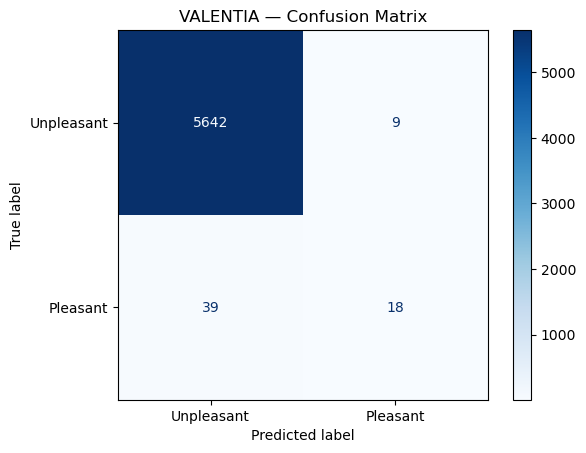

,Balanced_Accuracy,F1_Score_Weighted,Recall,Precision
Station,,,,
BASEL,0.7741,0.8294,0.6466,0.7119
BELGRADE,0.8141,0.8161,0.8124,0.7299
BUDAPEST,0.8393,0.8369,0.8567,0.7022
DEBILT,0.7472,0.8476,0.5514,0.7354
DUSSELDORF,0.7461,0.8254,0.5871,0.6606
HEATHROW,0.8020,0.8562,0.6967,0.7054
KASSEL,0.7493,0.9321,0.5214,0.6943
LJUBLJANA,0.8029,0.8285,0.7389,0.7113
MAASTRICHT,0.7691,0.8393,0.6284,0.6889


In [194]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    balanced_accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import matplotlib.pyplot as plt
import tensorflow as tf

# ------------------------------------
# 1. Setup and Station Config
# ------------------------------------
stations = ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW',
            'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB',
            'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']

weather_features = ['cloud_cover', 'humidity', 'pressure', 'global_radiation',
                    'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']

# Hyperparameters
timesteps = 30
batch_size = 16
epochs = 30
n_hidden = 16
metrics_table = []
histories = []

# ------------------------------------
# 2. Station Loop
# ------------------------------------
for station in stations:
    print(f"\n🌀 Processing station: {station}")

    # --- 2.1 Slice Data ---
    station_cols = [f"{station}_{f}" for f in weather_features]
    X_df = df_unscaled[station_cols].copy()
    y_df = pleas_ans[[f"{station}_pleasant_weather"]].copy()

    # --- 2.2 Train-Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_df, y_df, test_size=0.25, random_state=42, shuffle=False
    )

    # --- 2.3 Z-Score Scaling (Train Only) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- 2.4 Create Sequences ---
    def create_sequences(X, y, window):
        Xs, ys = [], []
        for i in range(window, len(X)):
            Xs.append(X[i - window:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, timesteps)

    # --- 2.5 Model Definition ---
    model = Sequential()
    model.add(Input(shape=(timesteps, len(weather_features))))
    model.add(LSTM(n_hidden))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # --- 2.6 Train Model ---
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Append full history object for later learning curve plots
    histories.append(history)

    # --- 2.7 Predict and Evaluate ---
    y_pred_prob = model.predict(X_test_seq).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Handle SONNBLICK or any other 100%-single-class edge case
    if len(np.unique(y_test_seq)) < 2:
        print(f"⚠️ Skipping metrics and confusion matrix for {station} — Only one class present in y_test.")
        continue

    bal_acc = balanced_accuracy_score(y_test_seq, y_pred)
    f1 = f1_score(y_test_seq, y_pred, average='weighted')
    recall = recall_score(y_test_seq, y_pred)
    precision = precision_score(y_test_seq, y_pred)

    print(f"\n📊 Results for {station}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_seq, y_pred, target_names=['Unpleasant (0)', 'Pleasant (1)']))

    metrics_table.append({
        "Station": station,
        "Balanced_Accuracy": round(bal_acc, 4),
        "F1_Score_Weighted": round(f1, 4),
        "Recall": round(recall, 4),
        "Precision": round(precision, 4)
    })

    # --- 2.8 Confusion Matrix ---
    cm = confusion_matrix(y_test_seq, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unpleasant', 'Pleasant'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{station} — Confusion Matrix")
    plt.grid(False)
    plt.show()

# ------------------------------------
# 3. Final Summary Output (Manual Copy/Paste)
# ------------------------------------
results_df = pd.DataFrame(metrics_table)
results_df.set_index("Station", inplace=True)

# View as regular DataFrame (manual copy to Excel if needed)
results_df

#### The next script generates a grid of train & test learning curves to evaluate degree of model overfit at each weather station

C:\Users\dirk8\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


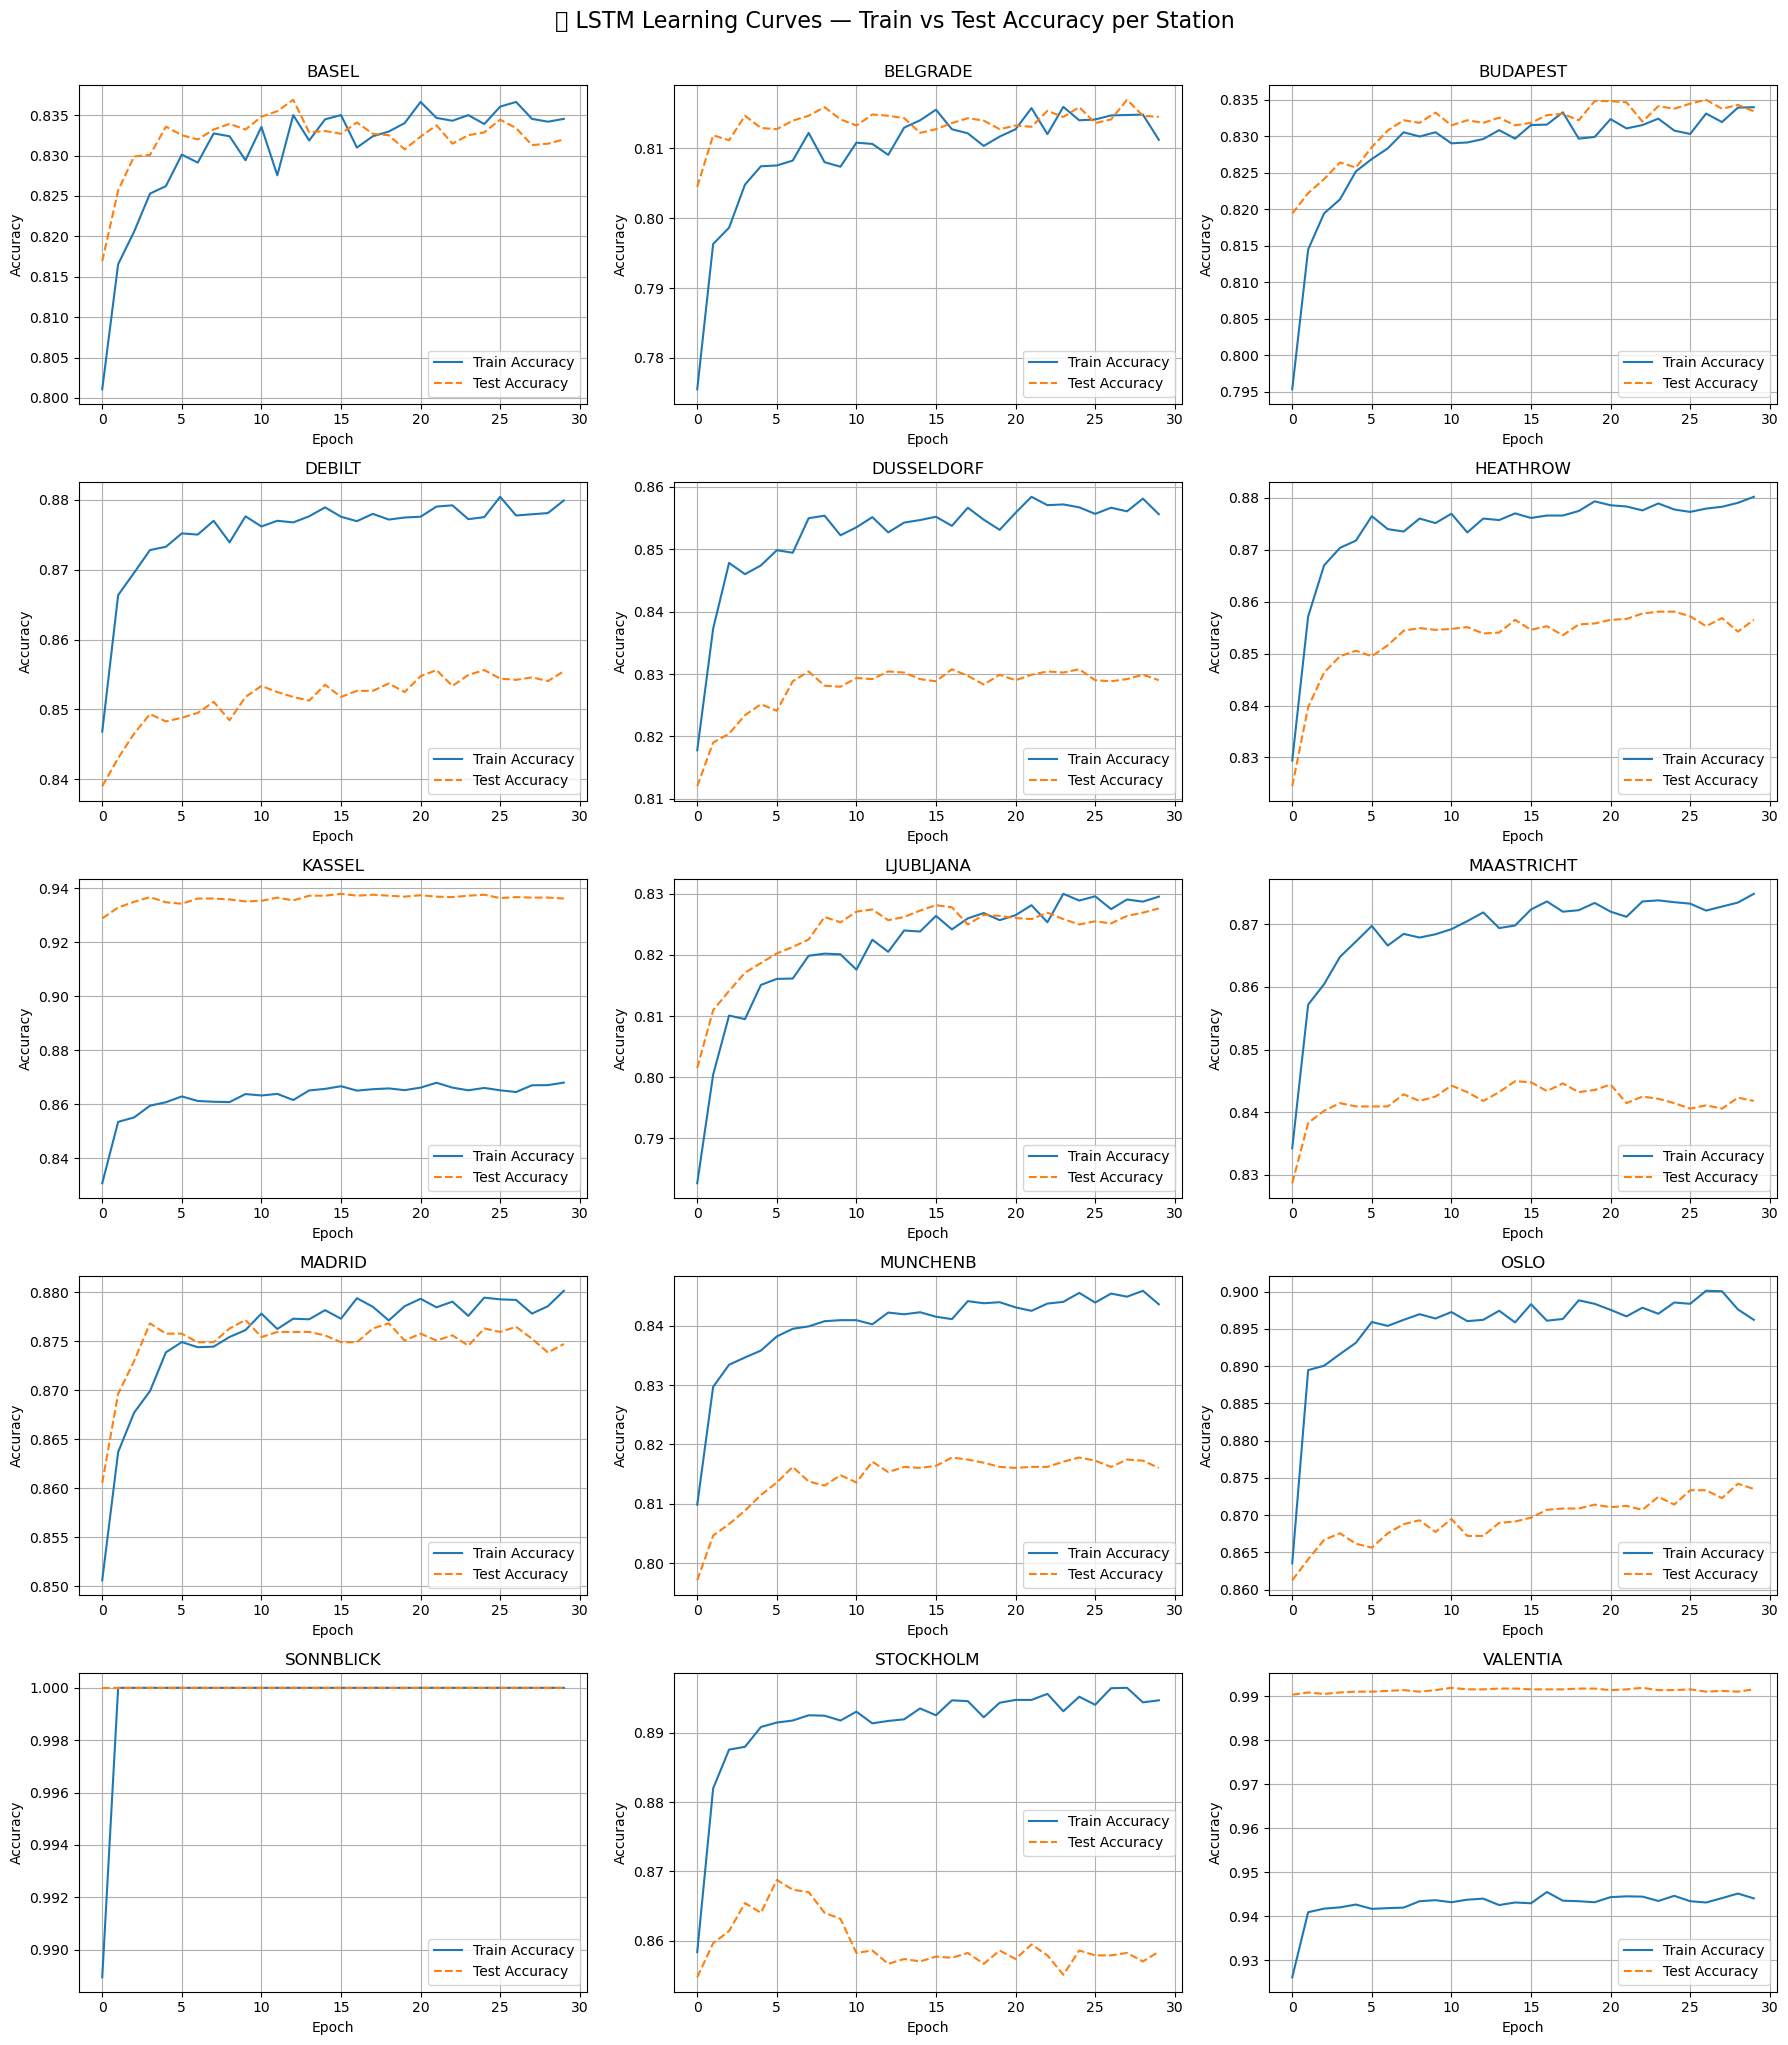

In [200]:
import matplotlib.pyplot as plt

# Use same station order as training loop
stations = ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW',
            'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB',
            'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA']

# Validate history length matches station count (just in case SONNBLICK was skipped)
if len(histories) != len(stations):
    print("⚠️ Mismatch between number of histories and stations — adjusting.")
    stations = stations[:len(histories)]

# Plot grid
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()

for idx, station in enumerate(stations):
    ax = axes[idx]
    history = histories[idx]
    
    ax.plot(history.history['accuracy'], label='Train Accuracy')
    ax.plot(history.history['val_accuracy'], label='Test Accuracy', linestyle='--')
    ax.set_title(station, fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(len(stations), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("📈 LSTM Learning Curves — Train vs Test Accuracy per Station", fontsize=16, y=1.02)
plt.show()